In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications import VGG19

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Reinhard/train/'
test_dir = "data-ICIAR/Reinhard/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_VGG19_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Reinhard/train/ 0
data-ICIAR/Reinhard/train/Benign 1155
data-ICIAR/Reinhard/train/InSitu 1155
data-ICIAR/Reinhard/train/Invasive 1155
data-ICIAR/Reinhard/train/Normal 1155
******************************
data-ICIAR/Reinhard/test/ 0
data-ICIAR/Reinhard/test/Benign 25
data-ICIAR/Reinhard/test/InSitu 25
data-ICIAR/Reinhard/test/Invasive 25
data-ICIAR/Reinhard/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
model = VGG19(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1


In [12]:
# print(model.layers[11].name)

In [13]:
c1 = model.layers[4].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[7].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[12].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[17].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 1s - loss: 1.4147 - acc: 0.4308 - val_loss: 1.0581 - val_acc: 0.5885
Epoch 2/1000
 - 0s - loss: 1.0631 - acc: 0.5435 - val_loss: 1.0446 - val_acc: 0.5365
Epoch 3/1000
 - 0s - loss: 0.9876 - acc: 0.5761 - val_loss: 0.9447 - val_acc: 0.5946
Epoch 4/1000
 - 0s - loss: 0.9190 - acc: 0.6185 - val_loss: 0.8103 - val_acc: 0.6910
Epoch 5/1000
 - 0s - loss: 0.8629 - acc: 0.6468 - val_loss: 0.7774 - val_acc: 0.7257
Epoch 6/1000
 - 0s - loss: 0.8222 - acc: 0.6742 - val_loss: 0.7160 - val_acc: 0.7378
Epoch 7/1000
 - 0s - loss: 0.7771 - acc: 0.6811 - val_loss: 0.7209 - val_acc: 0.7109
Epoch 8/1000
 - 0s - loss: 0.7424 - acc: 0.7108 - val_loss: 0.6422 - val_acc: 0.7830
Epoch 9/1000
 - 0s - loss: 0.7222 - acc: 0.7209 - val_loss: 0.6170 - val_acc: 0.7908
Epoch 10/1000
 - 0s - loss: 0.6814 - acc: 0.7405 - val_loss: 0.6104 - val_acc: 0.7648
Epoch 11/1000
 - 0s - loss: 0.6730 - acc: 0.7422 - val_loss: 0.5770 - val_acc: 0.7977
Epoch 12/1000
 

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.84


Confusion Matrix
[[21  1  2  1]
 [ 1 20  4  0]
 [ 0  2 23  0]
 [ 4  1  0 20]]


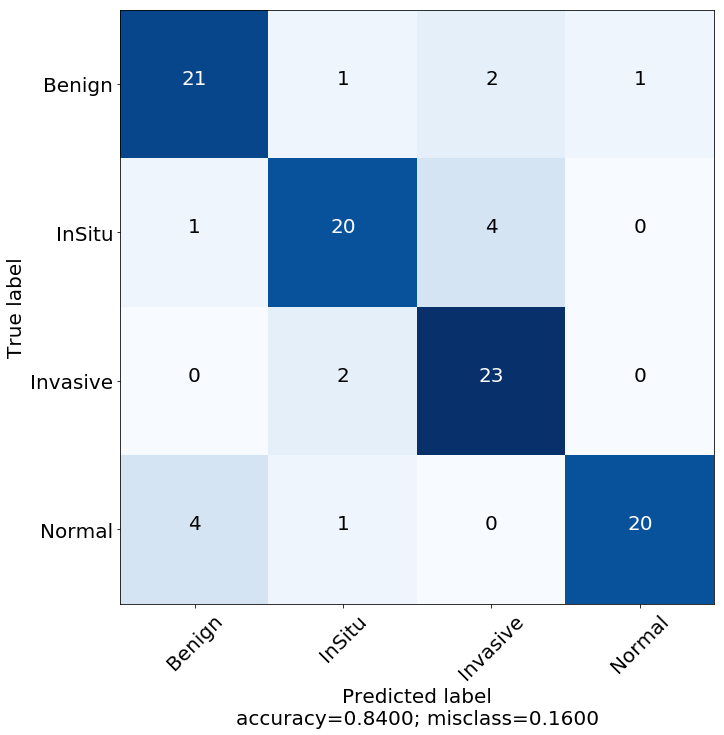

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  1  2  1]
 [ 1 20  4  0]
 [ 0  2 23  0]
 [ 4  1  0 20]]
              precision    recall  f1-score   support

    Invasive       0.81      0.84      0.82        25
      Normal       0.83      0.80      0.82        25
      Benign       0.79      0.92      0.85        25
      InSitu       0.95      0.80      0.87        25

   micro avg       0.84      0.84      0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.45454545454545
Specificity :  95.23809523809523


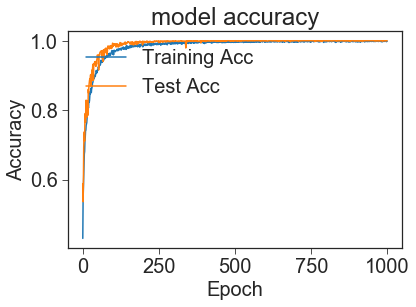

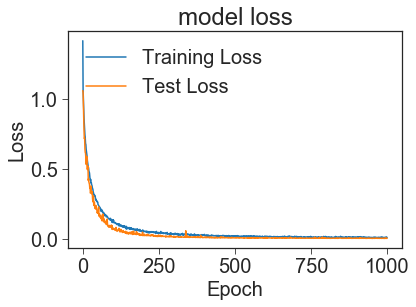

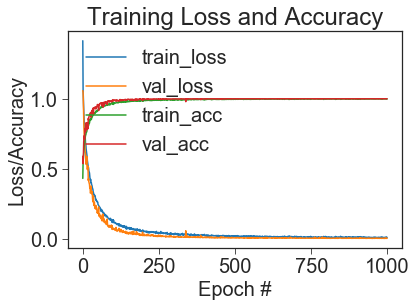

In [23]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")